In [48]:
#imports
import xarray as xr
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_predict, RandomizedSearchCV, cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from IPython.display import display
import cartopy.crs as ccrs
import cartopy.feature as cf
from sklearn.model_selection import learning_curve

In [2]:
def xr_open_dataset_custom(file :str, decode_times=True):
    """
    Wrapper function for xarray.open_dataset() but compatible with either .nc (netcdf) or .zarr files.
    
    Parameters
    ----------
    file : string
        The file location of an xarray dataset
    decode_times : bool, optional
        If True, decode times encoded in the standard NetCDF datetime format 
        into datetime objects. Otherwise, leave them encoded as numbers.
    
    Returns
    ----------
    xr : an xarray dataset object
    """
    
    #correct if a user specified a .nc but meant .zarr on Google cloud:
    updated_file = file
    if file.strip()[0:5] == 'gs://' and file.strip()[-3:] == '.nc': 
        updated_file = file.strip()[0:-3]+file.strip()[-3:].replace('.nc','.zarr')  #hardcoded for netcdfs

        
    try:
        xr_ds = xr.open_dataset(file, decode_times=decode_times) 
    except:
        try:
            xr_ds = xr.open_dataset(file, decode_times=decode_times, engine='zarr', chunks={})
        except:
            print(f'Encountered an error - trying with {updated_file}...')
            xr_ds = xr.open_dataset(updated_file, decode_times=decode_times, engine='zarr', chunks={}) 
            print('Success.')
        
    return xr_ds

In [30]:
list_for_df = ['SST_NOAA_OI-V2-1x1_2017-2022.nc', 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_2017-2022.nc', 'MLD_IFREMER-deBoyer_DT02-c1m-1x1_2017-2022.nc',
               'CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1_2017-2022.nc', 'xCO2_NOAA_xCO2-mm-gl-monthly_2017-2022.nc',
               'pCO2_LEAP_SOCAT-ERA5-fco2-weighted-gridded_2017-2022.nc'] 

xrfull = xr.merge([xr_open_dataset_custom(f) for f in list_for_df], compat='broadcast_equals')

xrfull.attrs = "" #just removing attribute details since wont be accurate anymore
#add time and space coordinates
xrfull = xrfull.assign( days_idx = xrfull.time.dt.dayofyear 
                       ,lon_rad = np.radians(xrfull.xlon)
                       ,lat_rad = np.radians(xrfull.ylat)
                      )
xrfull = xrfull.assign( T0 = np.cos(xrfull.days_idx * 2 * np.pi / 365)
                       ,T1 = np.sin(xrfull.days_idx * 2 * np.pi / 365)
                       ,A  = np.sin(xrfull.lat_rad)
                       ,B  = np.cos(xrfull.lat_rad)*np.sin(xrfull.lon_rad)
                       ,C  = -np.cos(xrfull.lat_rad)*np.cos(xrfull.lon_rad)
                      )



In [31]:
model_pco2_file_path = 'CESM_spco2_member_r10i1p1f1_2017-2022.nc'
model_pco2_file = xr.open_dataset(model_pco2_file_path)
model_pco2 = model_pco2_file.spco2

Text(0.5, 1.0, 'chlorophyll concentration')

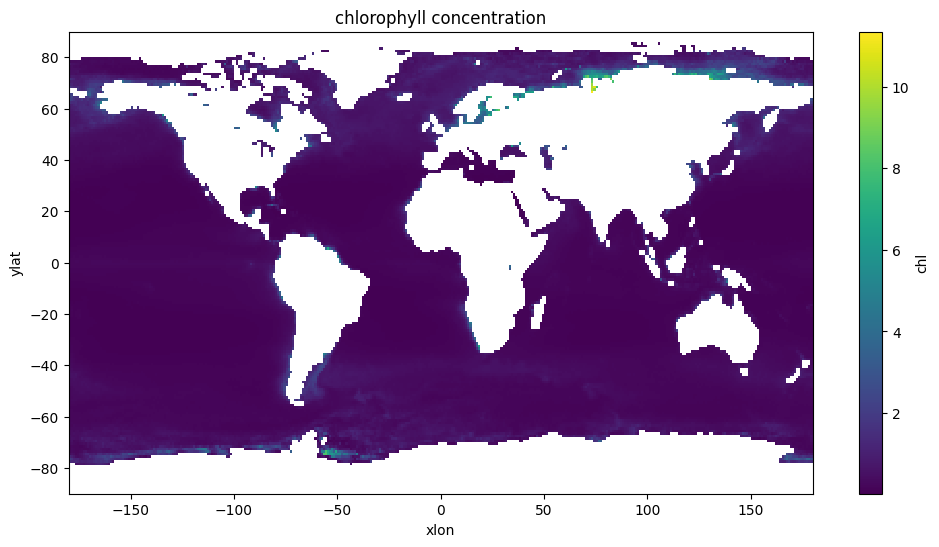

In [32]:
# sst, sss, chl and mld
#xrfull.chl.mean('time').plot()
fig, ax = plt.subplots(figsize=(12, 6))
xrfull.chl.mean('time').plot()
ax.set_title('chlorophyll concentration')


Text(0.5, 1.0, 'Sea Surface Temperature')

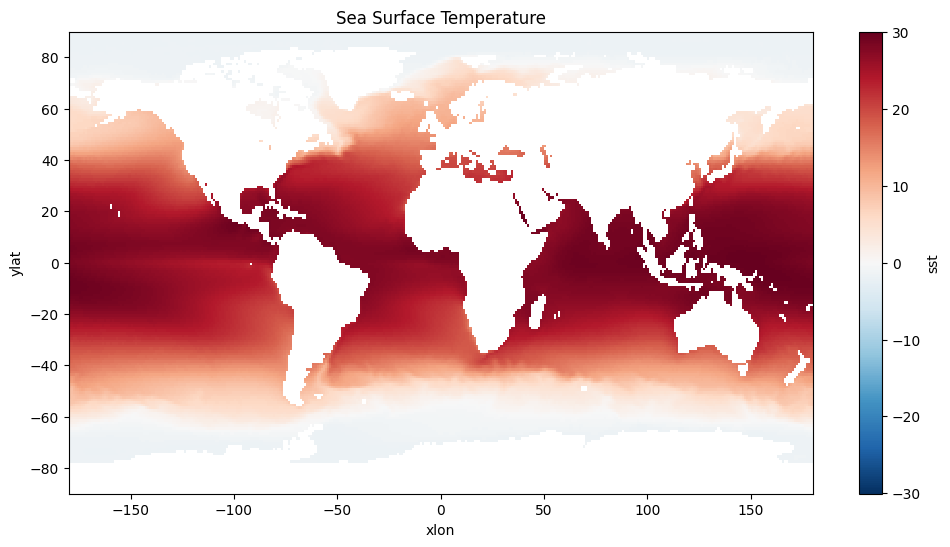

In [112]:
#xrfull.sst.mean('time').plot()  # For sea surface temperature
fig, ax = plt.subplots(figsize=(12, 6))
xrfull.sst.mean('time').plot()
ax.set_title('Sea Surface Temperature')


Text(0.5, 1.0, 'Sea Surface Salinity')

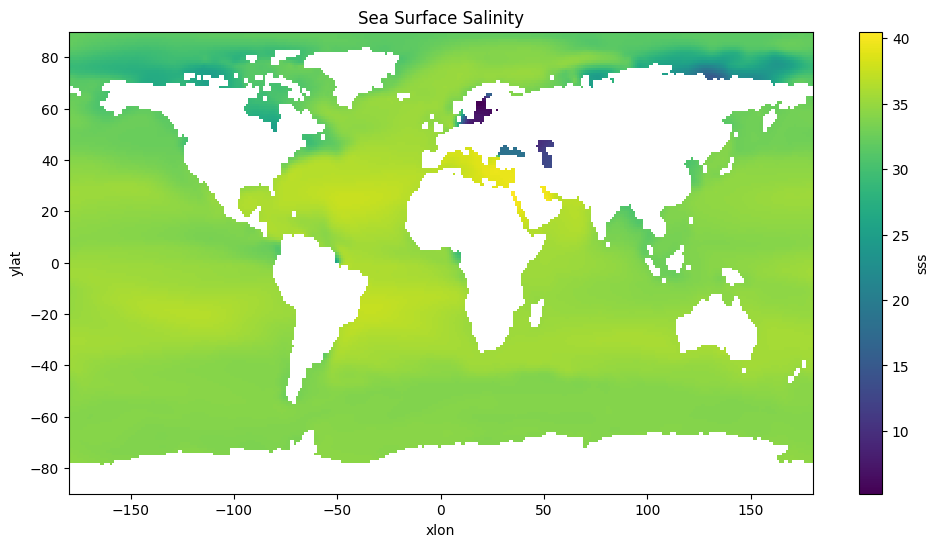

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
xrfull.sss.mean('time').plot()
ax.set_title('Sea Surface Salinity')




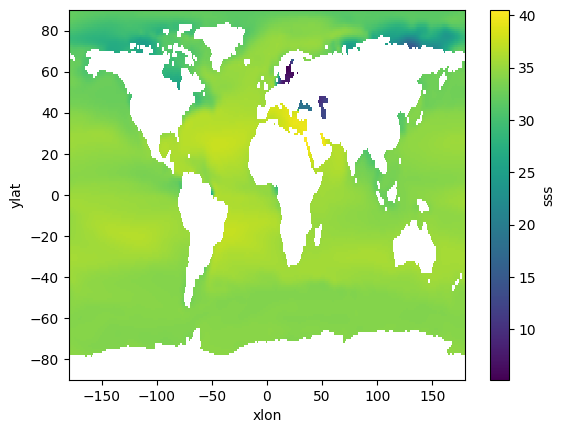

In [6]:
xrfull.sss.mean('time').plot()  # For sea surface salinity


Text(0.5, 1.0, 'Mixed Layer Depth')

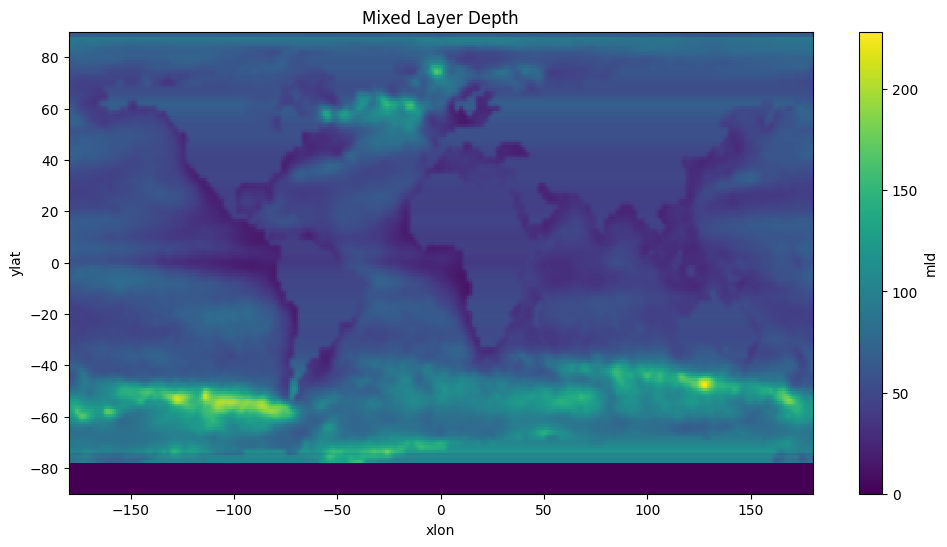

In [16]:
#xrfull.mld.mean('time').plot()  # For mixed layer depth
fig, ax = plt.subplots(figsize=(12, 6))
xrfull.mld.mean('time').plot()
ax.set_title('Mixed Layer Depth')


In [34]:
feature_list = ['sst', 'sss','chl','mld','xco2_trend' ,'T0', 'T1', 'A', 'B', 'C']
target = ['pco2']
xr_for_ml = xrfull.get(feature_list + target)
data = xr_for_ml.to_dataframe() 

df_for_ml = data.dropna(subset=feature_list + ["pco2"]) 


features = df_for_ml[feature_list]
target = df_for_ml['pco2']
iter2 = features.copy() # This will be used to re-map cooridinates onto analysis_df

In [35]:
iter2

sst        sss       chl        mld  xco2_trend  \
time       ylat  xlon                                                           
2017-01-15 -77.5 -174.5 -0.561592  34.312298  1.006923  48.303404      404.25   
                 -166.5 -0.212691  34.173893  1.414490  43.218227      404.25   
                 -165.5 -0.134523  34.145988  1.489401  44.106349      404.25   
                 -164.5 -0.123351  34.114403  3.746021  46.347953      404.25   
                 -161.5 -0.354371  34.021748  6.851186  37.527831      404.25   
...                           ...        ...       ...        ...         ...   
2022-12-15  67.5  12.5   7.856392  33.787796  2.102694  48.771646      418.13   
                  13.5   7.549054  33.641205  3.003061  40.768335      418.13   
            69.5  13.5   7.355166  34.583580  2.106477  84.980183      418.13   
                  14.5   7.375243  34.433208  1.964370  76.509524      418.13   
                  16.5   6.974340  34.088940  2.033140  51.148597      418.13   

                               T0        T1         A         B         C  
time       ylat  xlon                                                      
2017-01-15 -77.5 -174.5  0.966848  0.255353 -0.976296 -0.020745  0.215443  
                 -166.5  0.966848  0.255353 -0.976296 -0.050527  0.210459  
                 -165.5  0.966848  0.255353 -0.976296 -0.054192  0.209546  
                 -164.5  0.966848  0.255353 -0.976296 -0.057841  0.208568  
                 -161.5  0.966848  0.255353 -0.976296 -0.068677  0.205255  
...                           ...       ...       ...       ...       ...  
2022-12-15  67.5  12.5   0.962309 -0.271958  0.923880  0.082828 -0.373612  
                  13.5   0.962309 -0.271958  0.923880  0.089336 -0.372110  
            69.5  13.5   0.962309 -0.271958  0.936672  0.081754 -0.340531  
                  14.5   0.962309 -0.271958  0.936672  0.087685 -0.339052  
                  16.5   0.962309 -0.271958  0.936672  0.099464 -0.335786  

[70383 rows x 10 columns]

In [399]:

model = XGBRegressor(random_state=42)


param_distributions = {
    'n_estimators': [100, 200, 500, 700, 1000],  
    'max_depth': [3, 5, 7, 9],  
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 
    'subsample': [0.6, 0.7, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0], 
    'min_child_weight': [1, 3, 5, 7],  
    'reg_alpha': [1, 10, 20, 30, 45],  
    'reg_lambda': [10, 20, 30, 40, 50]  
}


kf = KFold(n_splits=5, shuffle=True, random_state=10)


pipeline = Pipeline([
    ('xgb', model)
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={'xgb__' + key: value for key, value in param_distributions.items()},
    n_iter=50, 
    scoring='r2',
    cv=kf,  
    verbose=1, 
    random_state=42,
    n_jobs=-1  
)


random_search.fit(features, target)


print("Best Parameters:", random_search.best_params_)
print("Best R2 Score:", random_search.best_score_)


best_model = random_search.best_estimator_


preds = cross_val_predict(best_model, features, target, cv=kf)


scores = cross_validate(best_model, features, target, cv=kf, scoring='r2', return_train_score=True)


print("\nCross-Validation Results:")
print("Train R2 Scores:", scores['train_score'])
print("Test R2 Scores:", scores['test_score'])
print("Mean Train R2:", np.mean(scores['train_score']))
print("Mean Test R2:", np.mean(scores['test_score']))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 20, 'xgb__reg_alpha': 20, 'xgb__n_estimators': 700, 'xgb__min_child_weight': 5, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.8}
Best R2 Score: 0.8802070097423262

Cross-Validation Results:
Train R2 Scores: [0.98878014 0.98882945 0.98871028 0.98878793 0.98901093]
Test R2 Scores: [0.88575497 0.88148519 0.88404932 0.87750481 0.87224075]
Mean Train R2: 0.9888237461398608
Mean Test R2: 0.8802070097423262


## Feature engineering Begins

In [9]:
features.reset_index(inplace=True)

features['sst_lat_trend'] = features['sst'] * features['B']

features['sss_north_south'] = features['sss'] * features['A']  


C:\Users\Sileo\AppData\Local\Temp\ipykernel_6936\957542763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['sst_lat_trend'] = features['sst'] * features['B']
C:\Users\Sileo\AppData\Local\Temp\ipykernel_6936\957542763.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['sss_north_south'] = features['sss'] * features['A']


In [10]:
features['region'] = pd.cut(
    features['ylat'], bins=[-90, -30, 30, 90], labels=['South', 'Middle', 'North']
)


features['month'] = pd.to_datetime(features['time']).dt.month


def get_season(month, ylat):
    if ylat >= 0: 
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'
    else:  
        if month in [12, 1, 2]: return 'Summer'
        elif month in [3, 4, 5]: return 'Autumn'
        elif month in [6, 7, 8]: return 'Winter'
        else: return 'Spring'


features['season'] = features.apply(lambda row: get_season(row['month'], row['ylat']), axis=1)



features = features.drop(columns=['time', 'ylat', 'xlon'])


features = pd.get_dummies(features, columns=['season', 'region'], drop_first=True) 
analysis_df = features.copy() #Data anlysis purposes and for re-assigning our training set

C:\Users\Sileo\AppData\Local\Temp\ipykernel_6936\3889055255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['region'] = pd.cut(
C:\Users\Sileo\AppData\Local\Temp\ipykernel_6936\3889055255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['month'] = pd.to_datetime(features['time']).dt.month
C:\Users\Sileo\AppData\Local\Temp\ipykernel_6936\3889055255.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [12]:

feature_list = features.loc[:, [col for col in feature_list if col not in ['ylat', 'xlon']]]


In [15]:
best_params = {
    'subsample': 0.8,
    'reg_lambda': 20,
    'reg_alpha': 20,
    'n_estimators': 700,
    'min_child_weight': 5,
    'max_depth': 9,
    'learning_rate': 0.2,
    'colsample_bytree': 0.8
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)


best_model = XGBRegressor()


best_model.set_params(**best_params)


scores = cross_validate(
    best_model, 
    features, 
    target, 
    cv=kf, 
    return_train_score=True
)


preds = cross_val_predict(best_model, features, target, cv=kf)


print("Mean Test Score:", scores['test_score'].mean(), "Mean Train Score:",scores['train_score'].mean())



Mean Test Score: 0.8812414022690774 Mean Train Score: 0.9895811420737761


We now test our new scores with additional features (features['sst_lat_trend'], features['sss_north_south'])

In [16]:
X = analysis_df
y = target.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = xgb.XGBRegressor(alpha = 45, n_estimators = 700, max_depth = 7,subsample = 0.6, reg_lambda = 30 ,eta = .15, colsample_bytree = 0.8, min_child_weight = 3)

scores = cross_validate(best_model, X, target, cv = KFold(n_splits=5, shuffle = True, random_state=10), return_train_score=True)

preds = cross_val_predict(model, X, y, cv=kf)

In [18]:
analysis_df['residuals'] = y - preds
analysis_df['squared_error'] = analysis_df['residuals'] ** 2
print(scores['test_score'].mean(), scores['train_score'].mean())

0.8835549522987243 0.9894525583558991


## Visualizing and analyzing our results begins 

In [19]:
analysis_df['region'] = analysis_df[['region_Middle', 'region_North']].apply(
    lambda row: 'Middle' if row['region_Middle'] == 1 else 
                'North' if row['region_North'] == 1 else 'South', axis=1
)


analysis_df['season'] = analysis_df[['season_Spring', 'season_Summer', 'season_Winter']].apply(
    lambda row: 'Spring' if row['season_Spring'] == 1 else 
                'Summer' if row['season_Summer'] == 1 else 
                'Winter' if row['season_Winter'] == 1 else 'Autumn', axis=1
)


print("MSE by Region:")
region_errors = analysis_df.groupby('region')['squared_error'].mean()
print(region_errors)


print("\nR2 Score by Region:")
for region in ['South', 'Middle', 'North']:
    mask = analysis_df['region'] == region
    r2 = r2_score(y[mask], preds[mask])
    print(f"R2 for {region}: {r2:.3f}")


print("\nMSE by Season:")
season_errors = analysis_df.groupby('season')['squared_error'].mean()
print(season_errors)

print("\nR2 Score by Season:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    mask = analysis_df['season'] == season
    r2 = r2_score(y[mask], preds[mask])
    print(f"R2 for {season}: {r2:.3f}")


MSE by Region:
region
Middle    121.755104
North     300.900456
South     190.350860
Name: squared_error, dtype: float64

R2 Score by Region:
R2 for South: 0.790
R2 for Middle: 0.875
R2 for North: 0.853

MSE by Season:
season
Autumn    192.623131
Spring    226.326814
Summer    279.488129
Winter     99.990688
Name: squared_error, dtype: float64

R2 Score by Season:
R2 for Winter: 0.906
R2 for Spring: 0.825
R2 for Summer: 0.876
R2 for Autumn: 0.864


In [36]:
# We repeat the process of adding predicted values back into original dataframe
iter2.loc[:, 'preds'] = preds  

iter2.loc[:, 'residuals'] = analysis_df['residuals'].values


iter2.loc[:, 'squared_error'] = analysis_df['squared_error'].values


iter2.head()


In [40]:
xarr_for_ml = xr.Dataset.from_dataframe(iter2)

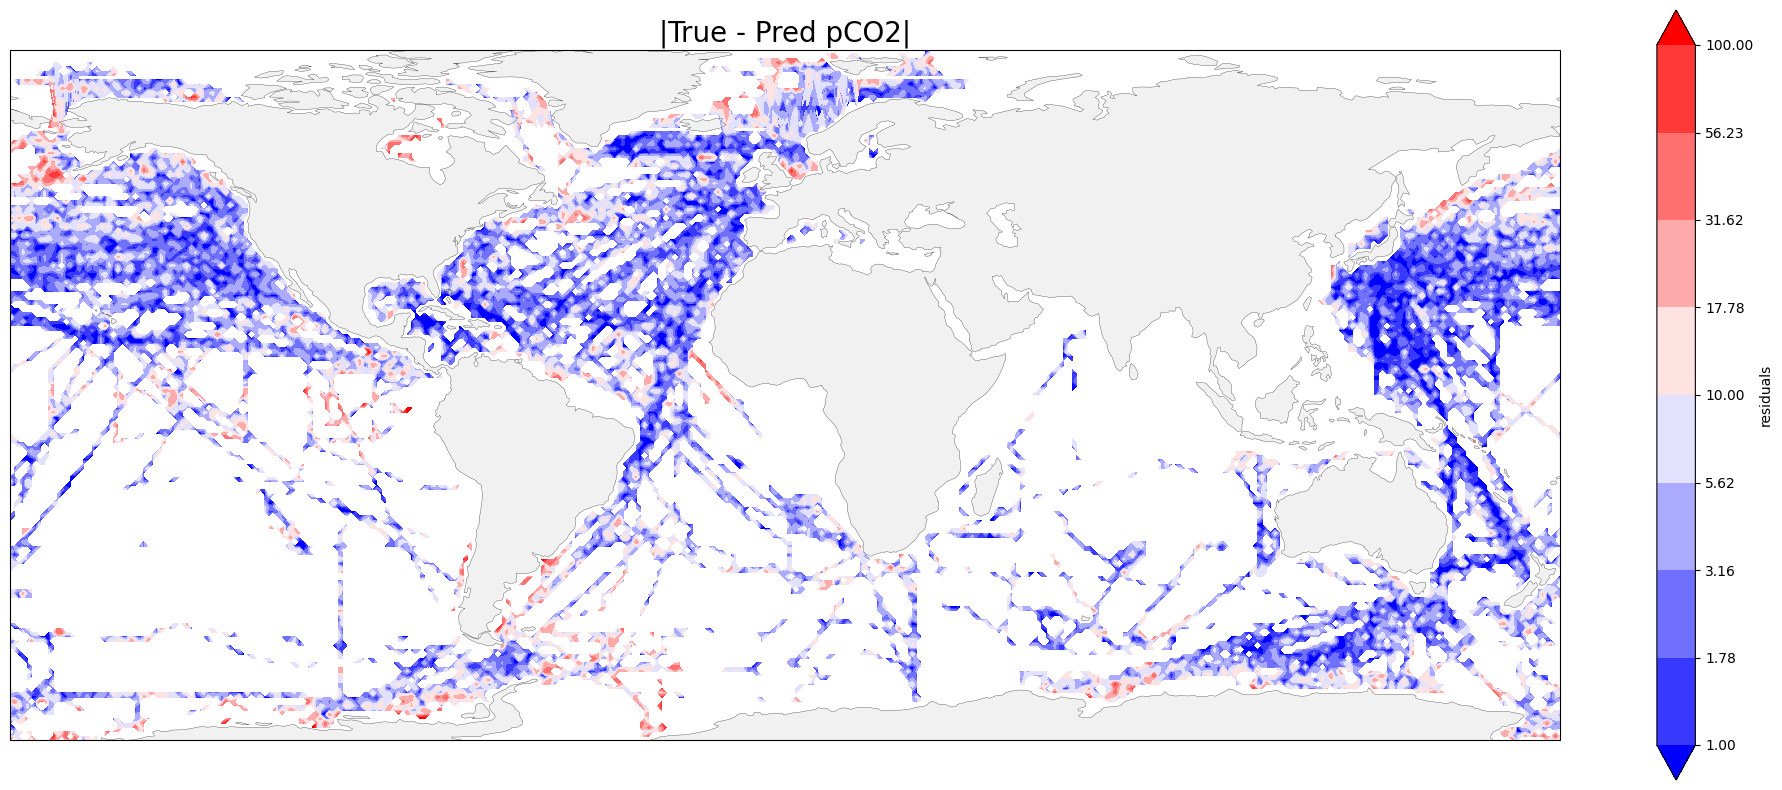

In [59]:
fig, ax = plt.subplots(1,1,figsize=(25,10),subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cf.LAND, facecolor='lightgrey', alpha=0.3)

Tlevels = np.logspace(0,2,9)

(np.abs(xarr_for_ml.residuals.mean('time')[:,:])).plot.contourf(ax=ax, levels = Tlevels, cmap='bwr', extend='both')

ax.coastlines(resolution='110m', lw=0.2)

ax.set_title('|True - Pred pCO2|', fontsize=20);


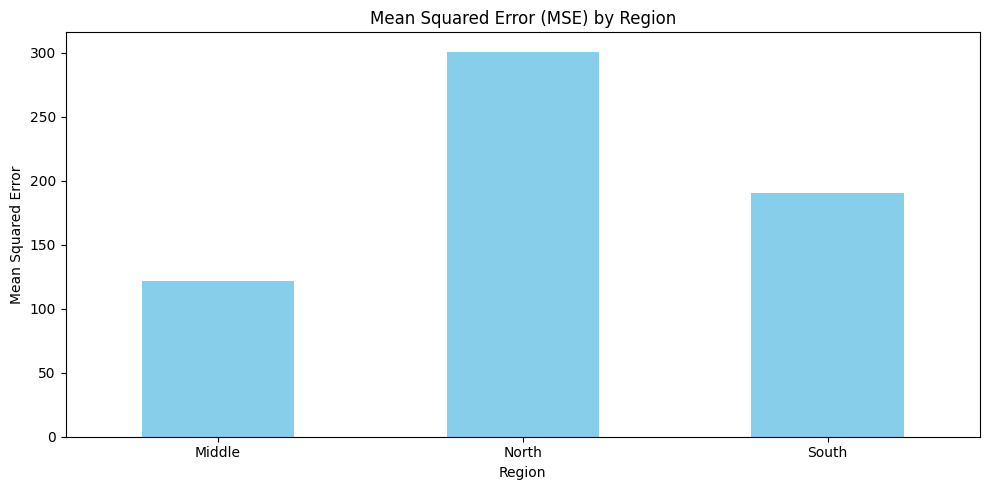

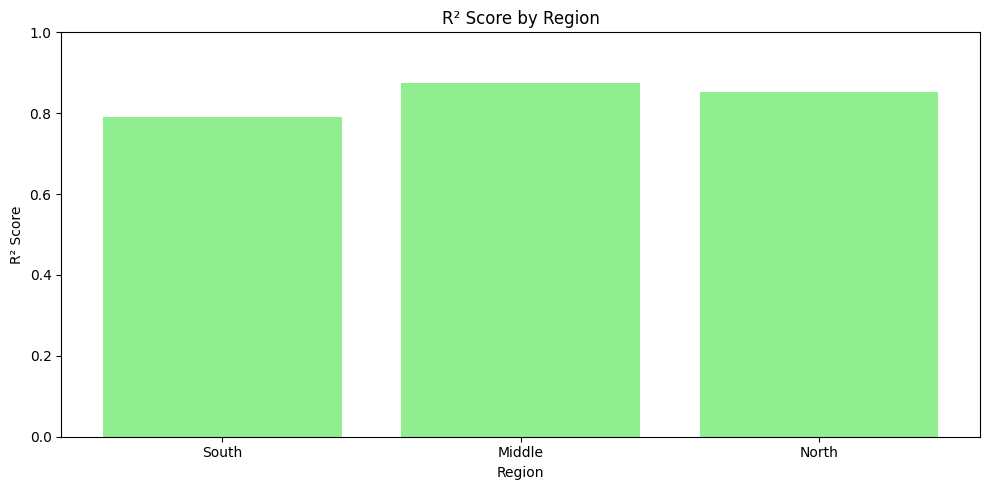

In [193]:

plt.figure(figsize=(10, 5))
region_errors.plot(kind='bar', color='skyblue')
plt.title("Mean Squared Error (MSE) by Region")
plt.xlabel("Region")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


r2_by_region = []
for region in ['South', 'Middle', 'North']:
    mask = analysis_df['region'] == region
    r2 = r2_score(y[mask], preds[mask])
    r2_by_region.append(r2)

plt.figure(figsize=(10, 5))
plt.bar(['South', 'Middle', 'North'], r2_by_region, color='lightgreen')
plt.title("R2 Score by Region")
plt.xlabel("Region")
plt.ylabel("R² Score")
plt.ylim(0, 1)  
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


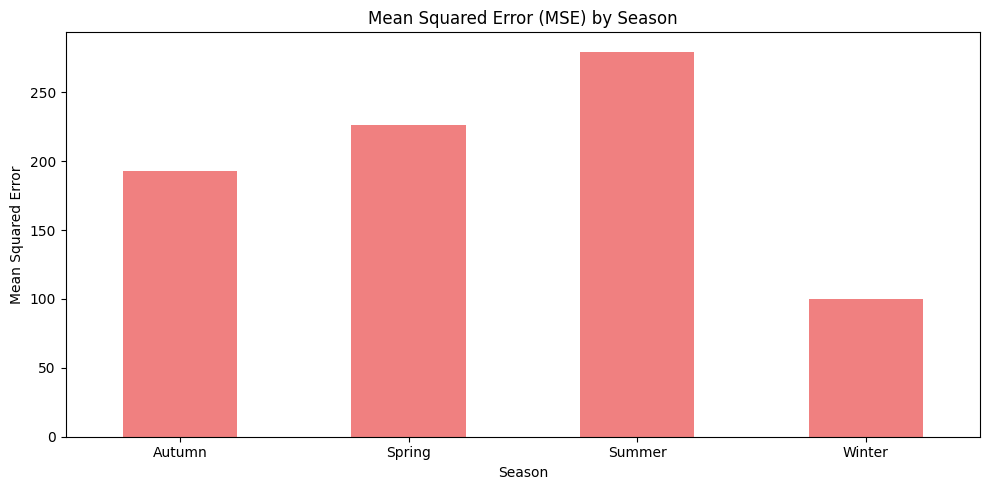

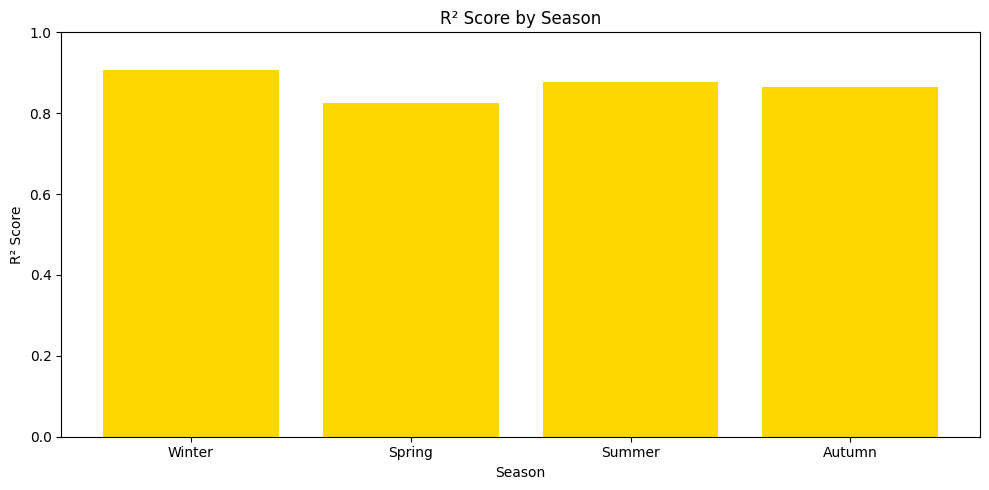

In [194]:
# Plot MSE by Season
plt.figure(figsize=(10, 5))
season_errors.plot(kind='bar', color='lightcoral')
plt.title("Mean Squared Error (MSE) by Season")
plt.xlabel("Season")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# R2 Score by Season
r2_by_season = []
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    mask = analysis_df['season'] == season
    r2 = r2_score(y[mask], preds[mask])
    r2_by_season.append(r2)

plt.figure(figsize=(10, 5))
plt.bar(['Winter', 'Spring', 'Summer', 'Autumn'], r2_by_season, color='gold')
plt.title("R² Score by Season")
plt.xlabel("Season")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


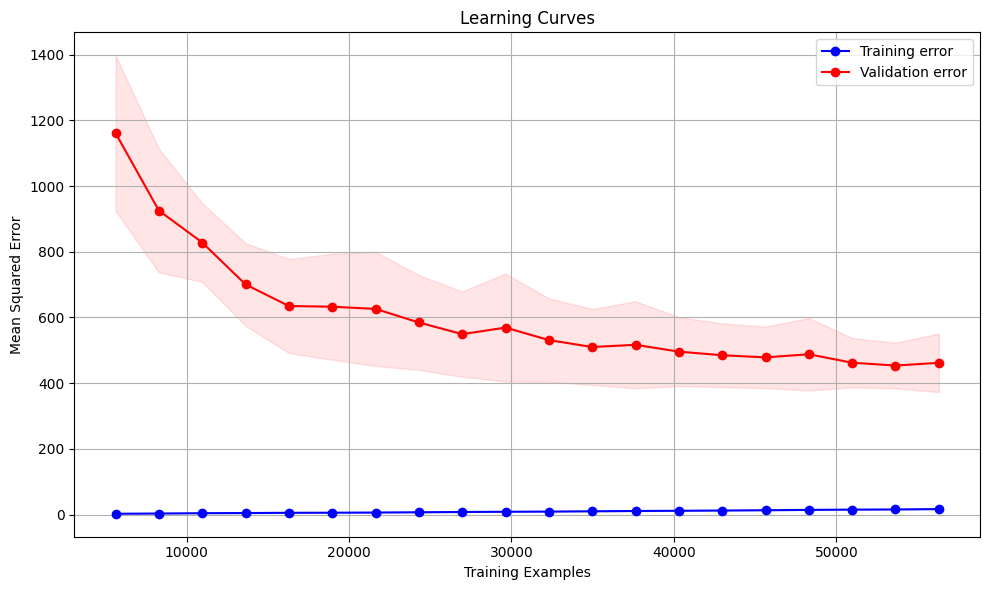

In [68]:


train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=features,
    y=target,
    cv=5,                 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, #CPU Power
    train_sizes = np.linspace(0.1, 1.0, 20)
  
)


train_mean = np.mean(-train_scores, axis=1)   
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)


plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training error')#Labels
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation error')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')

plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


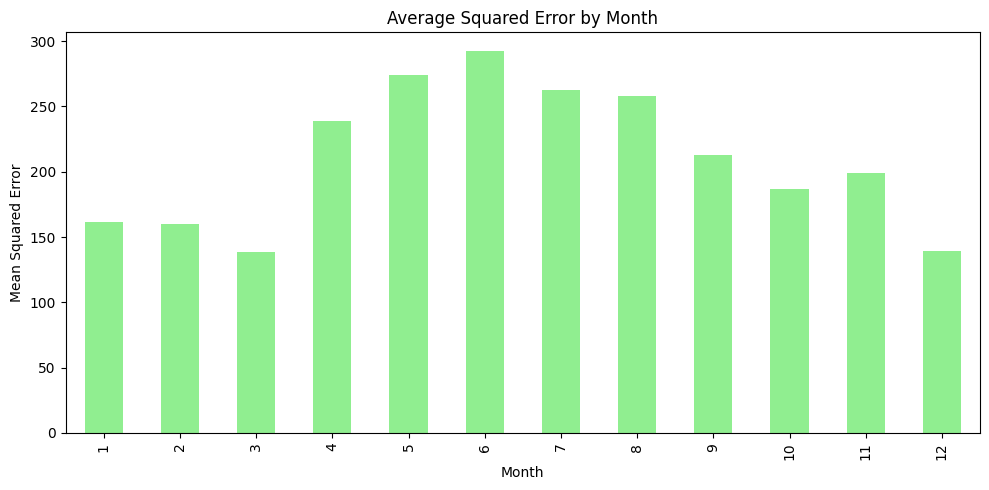

In [201]:
monthly_mean_error = analysis_df.groupby('month')['squared_error'].mean()

plt.figure(figsize=(10,5))
monthly_mean_error.plot(kind='bar', color='lightgreen')
plt.title("Average Squared Error by Month")
plt.xlabel("Month")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()


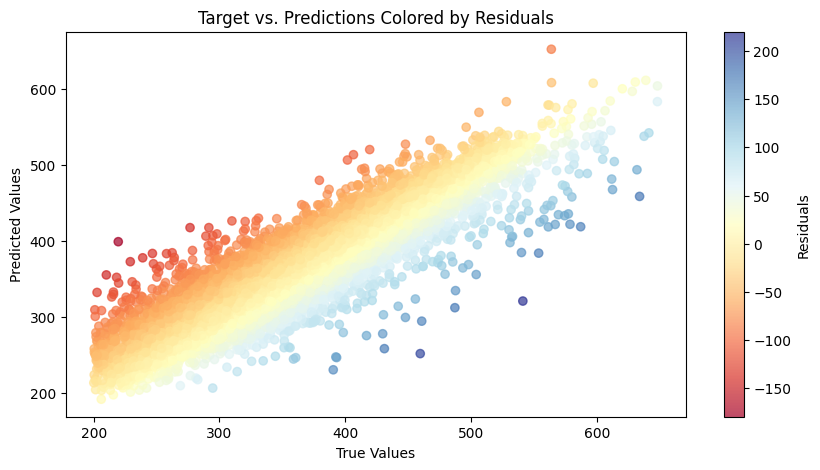

In [200]:
plt.figure(figsize=(10, 5))
sc = plt.scatter(x=target, y=preds, c=analysis_df['residuals'], cmap='RdYlBu', alpha=0.7)
plt.title("Target vs. Predictions Colored by Residuals")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.colorbar(sc, label='Residuals')
plt.show()


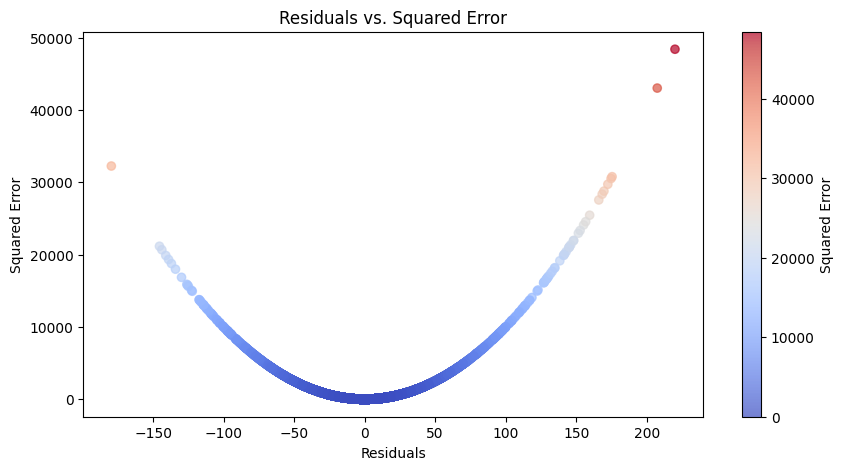

In [199]:
plt.figure(figsize=(10, 5))
plt.scatter(x=analysis_df['residuals'], y=analysis_df['squared_error'], 
            c=analysis_df['squared_error'], cmap='coolwarm', alpha=0.7)
plt.title("Residuals vs. Squared Error")
plt.xlabel("Residuals")
plt.ylabel("Squared Error")
plt.colorbar(label='Squared Error')
plt.show()


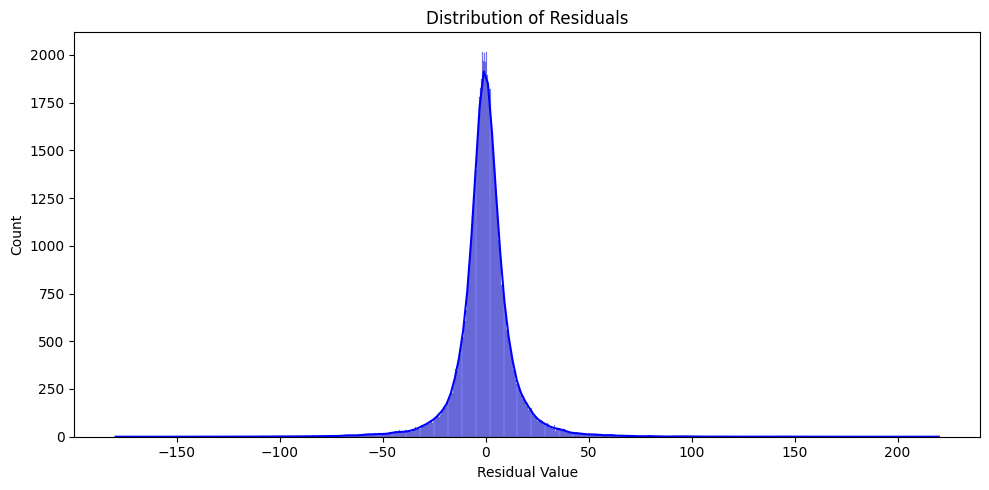

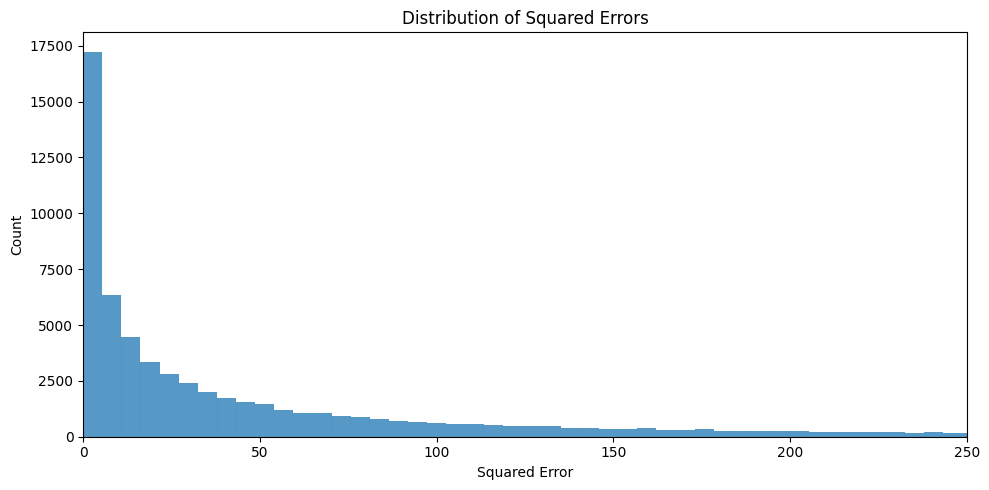

In [210]:

plt.figure(figsize=(10, 5))
sns.histplot(analysis_df['residuals'], kde=True, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Distribution of squared errors
plt.figure(figsize=(10, 5))
sns.histplot(analysis_df['squared_error'])
plt.title("Distribution of Squared Errors")
plt.xlabel("Squared Error")
plt.ylabel("Count")
plt.xlim(0, 250)

plt.tight_layout()
plt.show()


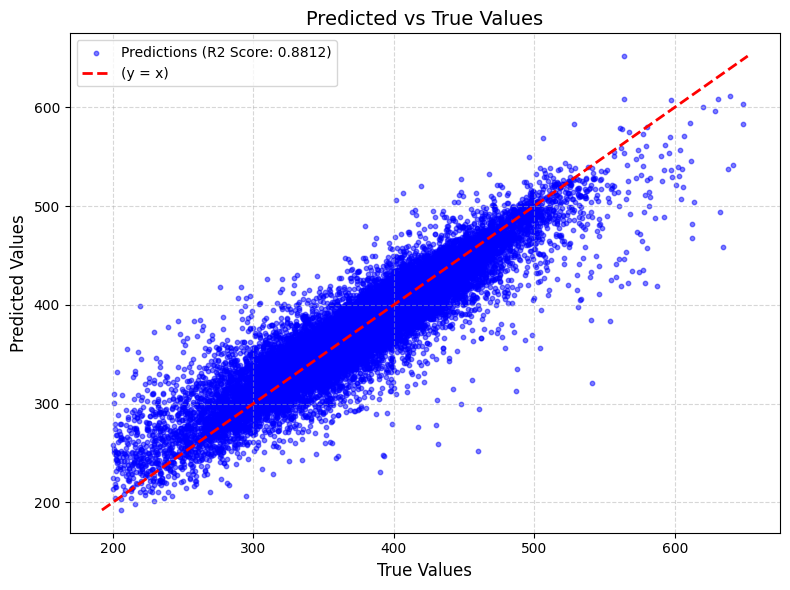

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.5, s=10, label='Predictions (R2 Score: 0.8812)')  


min_val = min(np.min(target), np.min(preds))
max_val = max(np.max(target), np.max(preds))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='(y = x)')


plt.title('Predicted vs True Values', fontsize=14)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.5)


plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [57]:
scores['test_score'].mean(), scores['train_score'].mean()

(0.8405937035705998, 0.8897015814395932)

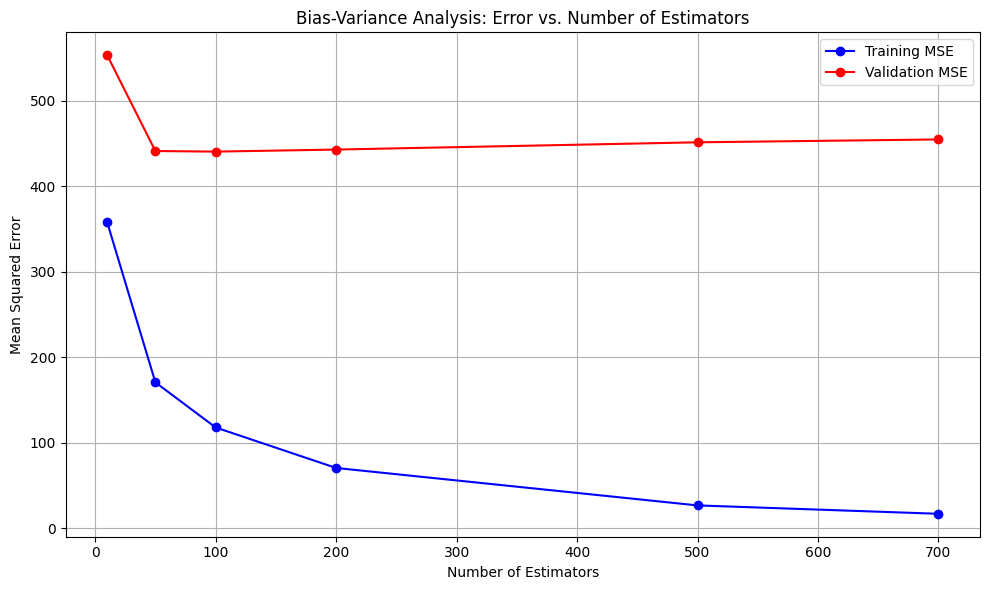

In [64]:
n_estimators_range = [10, 50, 100, 200, 500, 700] #defining our estimator range
train_scores_list = []
test_scores_list = []

for n in n_estimators_range:
    temp_model = best_model.set_params(n_estimators=n)
    scores = cross_val_score(temp_model, features, target, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    test_scores_list.append(scores.mean())
    
    results = cross_validate(temp_model, features, target, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
    train_scores_list.append(results['train_score'].mean())

train_mse = [-s for s in train_scores_list]
test_mse  = [-s for s in test_scores_list]

plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_mse, 'o-', label='Training MSE', color='blue')
plt.plot(n_estimators_range, test_mse, 'o-', label='Validation MSE', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Analysis: Error vs. Number of Estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
xarr_for_ml

<xarray.Dataset> Size: 384MB
Dimensions:        (time: 72, ylat: 161, xlon: 360)
Coordinates:
  * time           (time) datetime64[ns] 576B 2017-01-15 ... 2022-12-15
  * ylat           (ylat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 80.5 81.5 82.5
  * xlon           (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables: (12/13)
    sst            (time, ylat, xlon) float32 17MB nan nan nan ... nan nan nan
    sss            (time, ylat, xlon) float32 17MB nan nan nan ... nan nan nan
    chl            (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    mld            (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    xco2_trend     (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    T0             (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    ...             ...
    A              (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    B              (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    C              (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    preds          (time, ylat, xlon) float32 17MB nan nan nan ... nan nan nan
    residuals      (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan
    squared_error  (time, ylat, xlon) float64 33MB nan nan nan ... nan nan nan

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
xrfull.sst.mean('time').plot()
ax.set_title('Sea Surface Temperature')
